# Prediction on one parcel 
Given a run name, the corresponding trained model is loaded and used to predict the target variable for a given parcel. 
The prediction is shown as figures. 

In [1]:
import sys
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
sys.path.append("..")
from utils.helpers_config import load_personal_config, set_up_config, save_config, print_config
from utils.test.helpers_testing import load_test_dataset
import matplotlib.pyplot as plt
from utils.test.load_model import get_all_runs, get_loaded_model_and_criterion, get_model_and_model_path
from utils.helpers_mu import get_mus_from_config
from utils.test.one_parcel import plot_one_parcel_prediction, plot_spectral_bands
import argparse

In [2]:
local_dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
print("Local dataroot: ", local_dataroot)

Local dataroot:  C:\Users\anyam\elects_data


Download the model from wandb


In [3]:
entity, project, sweep = load_personal_config()
print(f"load sweep from entity: {entity}, project: {project}, sweep: {sweep}")
runs_df, runs = get_all_runs(entity, project)
df = runs_df[runs_df.sweep == sweep]

load sweep from entity: aurenore, project: MasterThesis, sweep: final_experience


give run name:

In [4]:
run_name = "v1"

In [5]:
# get the run with name:
run_idx = runs_df[runs_df.name == run_name].index[0]
run = runs[run_idx]
run_config = argparse.Namespace(**run.config)
model_artifact, model_path = get_model_and_model_path(run)

# get and save the config
config_path = save_config(model_path, run)
print_config(run)
args  = set_up_config(run_config)
args.dataroot = local_dataroot

wandb:   1 of 1 files downloaded.  


config file saved at:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\notebooks\artifacts\run-5dazxzo8-model.pth-v27\config.json
-------------------------------------------------- Configuration: --------------------------------------------------
mu: 150
mus: [122, 72, 102, 103, 150, 150, 150]
loss: daily_reward_piecewise_lin_regr
alpha: 1
device: cuda
epochs: 100
factor: v1
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /home/amauron/elects/data/elects_data
p_thresh: 0.7
patience: 30
snapshot: /home/amauron/elects/data/elects_snapshots/model.pth
batchsize: 128
corrected: True
alpha_decay: [1, 0.4]
hidden_dims: 128
loss_weight: balanced
weight_decay: 0
backbonemodel: LSTM
class_weights: [0.04731182754039765, 0.02670983411371708, 0.14316703379154205, 0.01290007308125496, 1, 0.011567785404622557, 0.010797104798257353]
decision_head: day
learning_rate: 0.001
nb_parameters: 264994
sequencelength: 365
validation_set: valid
daily_timestamps: True
day_head_init_bias: 1
percentage_a

load test dataset (this step can take some time)

In [6]:
test_ds, nclasses, class_names, input_dim = load_test_dataset(args)

2493572704 2493572704


loading data into RAM: 100%|██████████| 2463/2463 [00:04<00:00, 508.84it/s]


1555075632 1555075632


loading data into RAM: 100%|██████████| 36915/36915 [01:05<00:00, 560.94it/s]

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'orchards' 'permanent meadows'
 'temporary meadows']


## load the model 

In [7]:
# ## Load the models and the criterions
mus = get_mus_from_config(args)
model, criterion = get_loaded_model_and_criterion(run, nclasses, input_dim, mus=mus)
model.eval()

wandb:   1 of 1 files downloaded.  
c:\Users\anyam\Desktop\Master_thesis\Code\elects\notebooks\..\utils\test\load_model.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(run_config.class_weights)
c:\Users\anyam\Desktop\Master_thesis\Code\elects\notebooks\..\utils\train\helpers_training.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mus = torch.tensor(mus, dtype=torch.float)


loss daily_reward_piecewise_lin_regr selected, mus set to tensor([122,  72, 102, 103, 150, 150, 150])
model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\notebooks\artifacts\run-5dazxzo8-model.pth-v27
The model has 264,994 trainable parameters.


DailyEarlyRNN(
  (intransforms): Sequential(
    (0): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=13, out_features=128, bias=True)
  )
  (backbone): LSTM(128, 128, num_layers=2, bias=False, batch_first=True, dropout=0.2)
  (classification_head): ClassificationHead(
    (projection): Sequential(
      (0): Linear(in_features=128, out_features=7, bias=True)
      (1): LogSoftmax(dim=2)
    )
  )
  (stopping_decision_head): DecisionHeadDay(
    (projection): Sequential(
      (0): Linear(in_features=128, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)

## predict on one parcel 

In [8]:
id_parcel = 5
X, y_true, ids = test_ds[id_parcel]
X, y_true = X.to(args.device), y_true.to(args.device)
print("shapes: ", X.shape, y_true.shape)
print("ids: ", ids)
# change the shape of X to be able to use it in the model
X = X.unsqueeze(0)
y_true = y_true.unsqueeze(0)

shapes:  torch.Size([365, 13]) torch.Size([365])
ids:  5399696


predict the parcel: 

In [9]:
dict_pred = {"epoch": args.epochs, "criterion_alpha": args.alpha_decay[1]}
log_class_probabilities, stopping_criteria, predictions_at_t_stop, t_stop = model.predict(X, **dict_pred)
#  move to cpu 
log_class_probabilities = log_class_probabilities.cpu()
stopping_criteria = stopping_criteria.cpu()
predictions_at_t_stop = predictions_at_t_stop.cpu()
t_stop = t_stop.cpu()


Figure saved at: c:\Users\anyam\Desktop\Master_thesis\Code\elects\notebooks\artifacts\run-5dazxzo8-model.pth-v27\one_parcel_prediction_class_prob.png
Figure saved at: c:\Users\anyam\Desktop\Master_thesis\Code\elects\notebooks\artifacts\run-5dazxzo8-model.pth-v27\one_parcel_prediction_timestamps_left.png
Predicted label:  temporary meadows
True label:  temporary meadows


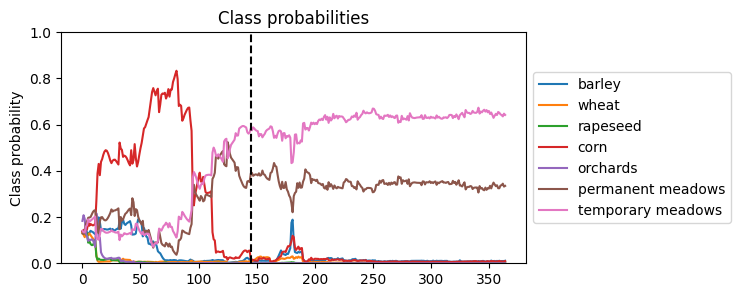

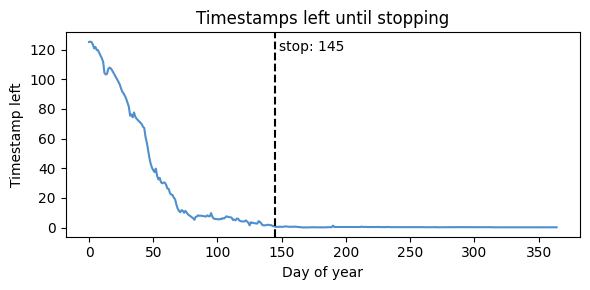

In [10]:
plot_one_parcel_prediction(class_names, log_class_probabilities, stopping_criteria, predictions_at_t_stop, t_stop, y_true, model_path)

plot the spectral bands:

In [11]:
# transfer the data to the cpu
X = X.cpu().detach().numpy().squeeze()

Figure saved at: c:\Users\anyam\Desktop\Master_thesis\Code\elects\notebooks\artifacts\run-5dazxzo8-model.pth-v27\one_parcel_data.png


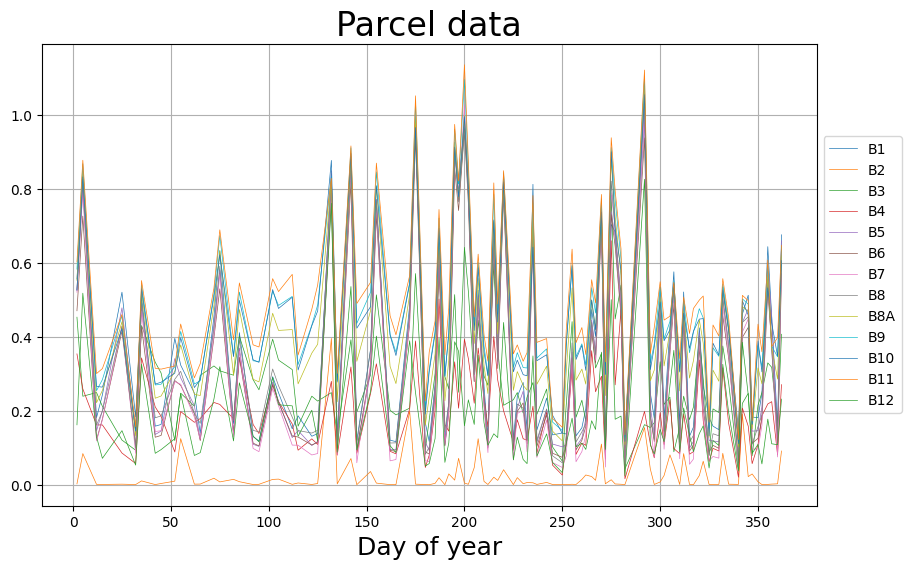

In [12]:
fig, ax = plt.subplots(1, figsize=(10,6))
plot_spectral_bands(X, fig, ax, model_path)
